# Preprocessing Graph Datasets
> Pre-processing, normalising, loading and batching graph datasets.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from os import path

import networkx as nx
from simgnn.datautils import simple_moving_average,load_array, load_graph

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (7,7) # use larger for presentation
matplotlib.rcParams['font.size']= 14 # use 14 for presentation

In [3]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import to_networkx, from_networkx
import torch_geometric.transforms as T

from simgnn.datasets import VertexDynamics, HaraMovies, HaraAblation, CellData
from simgnn.transforms import Pos2Vec, ScaleVelocity, ScaleTension, ScalePressure

In [4]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'Defaults:\n |-device: {device}\n |-dtype : {dtype}')

Defaults:
 |-device: cpu
 |-dtype : torch.float32


## Processing Amnioserosa Movies (Hara Movies Dataset)

### Applying Moving Average to Vertex Trajectories

In [5]:
SAMPLE_NAME = 'Seg_001'
root_dir = 'simgnn_data/hara_movies/raw/'
dataDir = path.join(root_dir, SAMPLE_NAME)

edges_index = load_array(path.join(dataDir, 'edges_index.npy'))
node2cell_index = load_array(path.join(dataDir, 'node2cell_index.npy'))
v_pos = load_array(path.join(dataDir, 'vtx_pos.npy'))
eij_lens = load_array(path.join(dataDir, 'edge_Length.npy'))

- plot edge lengths over time

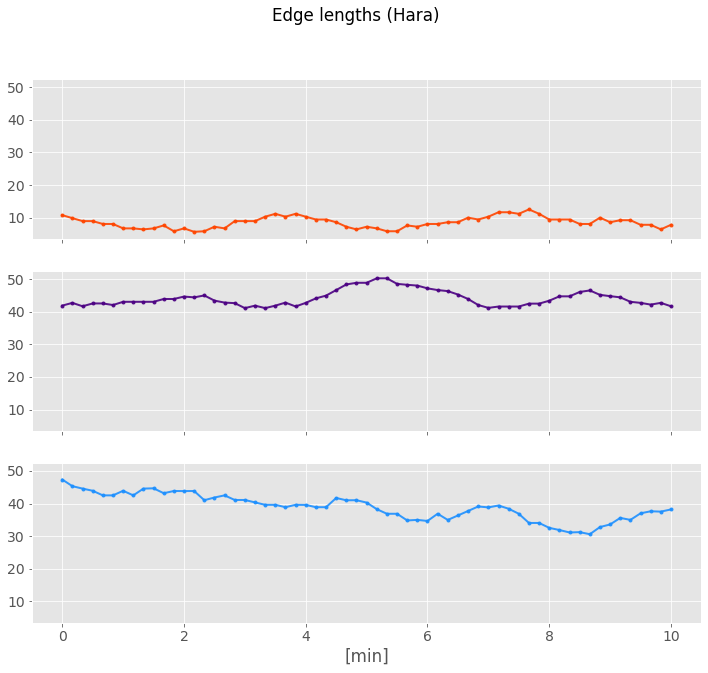

In [6]:
fig,axs = plt.subplots(nrows=3,ncols=1,sharex=True,sharey=True, figsize=[12,10])
t = np.arange(eij_lens.shape[0])/6
for ax,e_id,c in zip(axs,  [14, 119, 147], ['orangered', 'indigo', 'dodgerblue']):
    ax.plot(t,eij_lens[:,e_id],'.-', lw=2, alpha=.9, color = c)    

ax.set_xlabel('[min]')
plt.suptitle(f'Edge lengths (Hara)')
plt.show()

---
**Simple Moving Avegerage** of positions

In [25]:
t_lag = 4
v_pos_sma = simple_moving_average(v_pos, lag_time=t_lag)

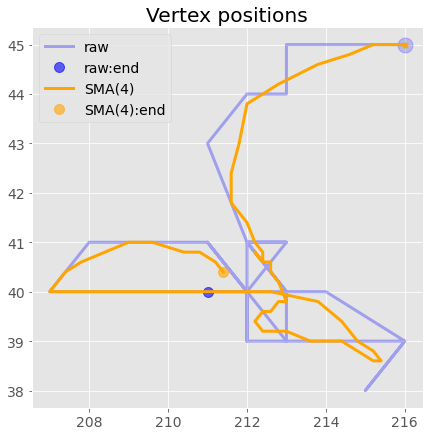

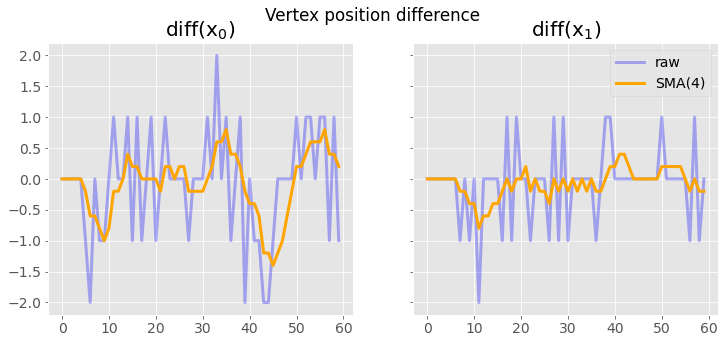

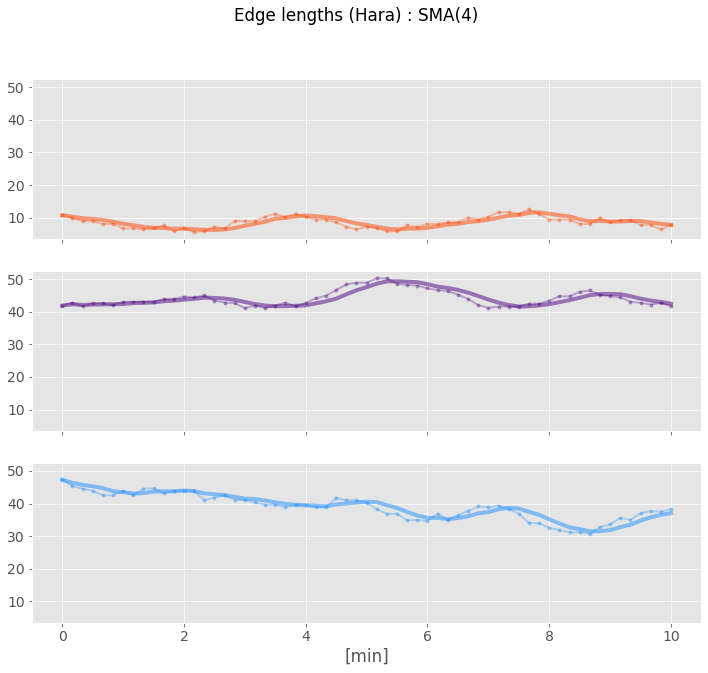

In [26]:
PLOT_SMA = True
# plot vertex trajectory
plt.figure(figsize=[7,7])
plt.plot(v_pos[:,0,0],v_pos[:,0,1],'blue',alpha=.3 if PLOT_SMA else 0.7,lw=3, label='raw')
plt.plot(v_pos[0,0,0],v_pos[0,0,1],'o',c='blue',alpha=.2,ms=15)
plt.plot(v_pos[-1,0,0],v_pos[-1,0,1],'o',c='blue',alpha=.6,ms=10, label='raw:end')
if PLOT_SMA:
    plt.plot(v_pos_sma[:,0,0],v_pos_sma[:,0,1],'orange',lw=3,label=f'SMA({t_lag})')
    plt.plot(v_pos_sma[0,0,0],v_pos_sma[0,0,1],'o',c='orange',alpha=.9,ms=5)
    plt.plot(v_pos_sma[-1,0,0],v_pos_sma[-1,0,1],'o',c='orange',alpha=.6,ms=10,label=f'SMA({t_lag}):end')
plt.legend()
plt.title('Vertex positions');
plt.show()

# velocity
fig,axs = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True, figsize=[12,5])
for k,ax in enumerate(axs):
    ax.plot(np.diff(v_pos[:,0,k]),'blue',alpha=.3 if PLOT_SMA else 0.7, lw=3, label='raw')
    if PLOT_SMA:
        ax.plot(np.diff(v_pos_sma[:,0,k]),'orange',lw=3,label=f'SMA({t_lag})')
        ax.set_title(f'diff(x$_{k}$)')
plt.legend();
plt.suptitle('Vertex position difference');
plt.show()

# edge lengths
fig,axs = plt.subplots(nrows=3,ncols=1,sharex=True,sharey=True, figsize=[12,10])
t = np.arange(eij_lens.shape[0])/6
for ax,e_id,c in zip(axs,  [14, 119, 147], ['orangered', 'indigo', 'dodgerblue']):
    ax.plot(t,eij_lens[:,e_id],'.-', lw=2, alpha=.3, color = c)
    e_id_len = np.sqrt(np.sum((v_pos_sma[:,edges_index[1,e_id],:] - v_pos_sma[:,edges_index[0,e_id],:])**2,axis=1))
    ax.plot(t,e_id_len, lw=4, alpha=.5, color = c);#normalised lengths over time
    
# ax.axis([0,60.5/6,-2.9,2.9])
ax.set_xlabel('[min]')
plt.suptitle(f'Edge lengths (Hara) : SMA({t_lag})')
plt.show()

---
**Simulated edges**

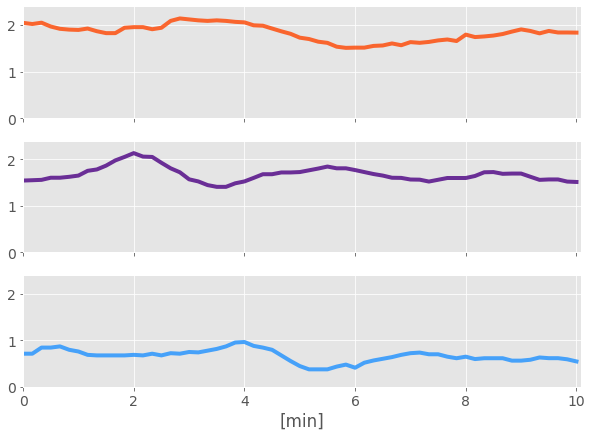

In [82]:
fig,axs = plt.subplots(nrows=3,ncols=1,sharex=True,sharey=True, figsize=[10,7])
t = np.arange(eij_lens.shape[0])/6
for ax,e_id,c in zip(axs,  [124, 102, 29], ['orangered', 'indigo', 'dodgerblue']):
    ax.plot(t,eij_lens[:,e_id]/26.32, lw=4, alpha=.8, color = c);#normalised lengths over time
ax.axis([0,60.5/6,0,2.4])
ax.set_xlabel('[min]')
plt.show()

In [17]:
ls 'simgnn_data/train/raw/17Nov2020/simul_Length.npy'

simgnn_data/train/raw/17Nov2020/simul_Length.npy*


## Hara Ablation Dataset

In [5]:
hara_abltn = HaraAblation('simgnn_data/hara_ablation/',smoothing=True, sma_lag_time=3)
hara_abltn

Processing...
Done!


HaraAblation(54)

In [8]:
hara_abltn[0]

CellData(cell2node_index=[2, 39], edge_index=[2, 29], edge_recoils=[29], node2cell_index=[2, 39], pos=[23, 2], x=[23, 5, 2])

## Synthetic Dataset and PyTorch Geometric

---
`VertexDynamics` internally computes **edge tension** and **cell pressure** attributes:

- Edge tensions
$$T_{edge:(i,j)} = \Lambda_{ij}(t)+2\cdot\sum_{k\in\{cells\ for\ (i,j)\}}K_p^{(k)}(p^{(k)}-p_0^{(k)})$$
- Cell pressures
$$\pi_{cell:k} = -2K_a^{(k)}(a^{(k)}-a_0^{(k)})$$
- `simgnn.datasets.VertexDynamics` (parent: `torch_geometric.data.Dataset`)

---

In [12]:
vtxdata = VertexDynamics('simgnn_data/train/')
print('len(vtxdata): {},\n> data:\n{}'.format(len(vtxdata), vtxdata[0]))

loader = DataLoader([vtxdata[0], vtxdata[25]], batch_size=2)
batch = next(iter(loader))
print('\n> batch of 2 examples:\n{}'.format(batch))
# nx.draw(to_networkx(batch, to_undirected=True),pos=dict(enumerate(batch.pos.numpy())), node_size=60)

len(vtxdata): 95,
> data:
CellData(cell2node_index=[2, 600], cell_pressures=[100], edge_index=[2, 339], edge_tensions=[339], node2cell_index=[2, 600], pos=[240, 2], x=[240, 5, 2], y=[240, 2])

> batch of 2 examples:
Batch(batch=[480], cell2node_index=[2, 1200], cell_pressures=[200], edge_index=[2, 678], edge_tensions=[678], node2cell_index=[2, 1200], pos=[480, 2], ptr=[3], x=[480, 5, 2], y=[480, 2])


In [10]:
# data = vtxdata[0]
# print(data)
# plt.figure(figsize=[10,10])
# plt.title('Monolayer Graph with Cell-to-Nodes Edges')
# nx.draw(to_networkx(data), pos=dict(enumerate(data.pos.numpy())), node_size=30)
# for ci in range(data.num_cells):
#     c_vxpos = data.pos[data.node2cell_index[0][data.node2cell_index[1]==ci]]
#     cpos = c_vxpos.mean(dim=0)
#     for vi in c_vxpos:
#         plt.plot([vi[0],cpos[0]],[vi[1],cpos[1]],lw=3,alpha=.5)
#     plt.plot(cpos[0],cpos[1],'bo',ms=10,alpha=.5)
# # plt.savefig('cell2node.png',dpi=100)

In [85]:
# cell_pos = np.stack([d1.pos[d1.cell2node_index[1,d1.cell2node_index[0]==c]].mean(dim=0).numpy() for c in range(d1.num_cells)])
# plt.figure(figsize=[20,20])
# nx.draw(to_networkx(d1),pos=dict(enumerate(d1.pos.numpy())), node_size=60)
# plt.plot(cell_pos[:,0],cell_pos[:,1],'ro',ms=10, alpha=.5)
# for c, c_pos in enumerate(cell_pos):
#     plt.text(c_pos[0],c_pos[1], f'{d1.cell_pressures[c]:.3f}') 

In [21]:
# t=5
# Dt = 1
# # plt.figure(figsize=[25,25])
# nx.draw(to_networkx(vtxdata[t], to_undirected=True),pos=dict(enumerate(vtxdata[t].pos.numpy())), node_size=60)
# nx.draw(to_networkx(vtxdata[t+Dt], to_undirected=True),pos=dict(enumerate(vtxdata[t+Dt].pos.numpy())),
#         node_size=20,width=4,
#         node_color='#FF00FF',edge_color='#51C5FF',alpha=.5)
# plt.quiver(vtxdata[t].pos.numpy()[:,0], vtxdata[t].pos.numpy()[:,1],
#            vtxdata[t].y.numpy()[:,0],vtxdata[t].y.numpy()[:,1],
#            units='xy',angles='xy',scale=.25,color='r')

## Data Normalisation

**Length unit** = average edge length (over whole dataset)
- divide all "edge lengths", node "speeds" and "velocities" by mean edge length $l_0$, this measures all len-s in $l_0$ units. 
- the real and the simulation datasets each will have its own average len. : $l^{(real)}_0$ and $l^{(sim)}_0$

**Normalisation** <br>
Normalising lengths, velocities (and areas) requires special considerations, since relative edge lengths and node vel-s are inputs to the GNN model and need to be in the same scale for both *simulated* and *real* datasets.
- `[ data.edge_attr ]` *edge directions* $e_i$, and *edge lens* $l_i$: since lengths are in range `[0, l_max]`, scale by **10 average lengths** (previously 20) and no mean shift to zero. We get
$$l^{norm}_i = \frac{l_i}{10\cdot{}l_0}$$
this scales lengths to values comparable to node velocity magnitudes which are about 1/20's of length or 5% of $l_0$ (the same is true for $e^{norm}_i$).
- `[ data.x, data.y ]` *node velocities* $\Delta{}v_i$: scale by **half average edge length** (previously 1 av. len.), $$\Delta{}v_i^{norm} = \frac{\Delta{}v_i}{0.5\cdot{}l_0}$$
this applies to both *node attributes and targets*.

- `l_0 = 0.857 (average edge length, simulated data)`

### Normalising Simulation Data

#### Sample with Constant Ka,Kp, A0,P0 (exponential modulation)

In [15]:
vtxdata = VertexDynamics('../../../dataDIR/simgnn_data/train/')
data = vtxdata[0]
data

CellData(cell2node_index=[2, 600], cell_pressures=[100], edge_index=[2, 339], edge_tensions=[339], node2cell_index=[2, 600], pos=[240, 2], x=[240, 5, 2], y=[240, 2])

In [68]:
# Normalisation: for simulated data
Tnorm = T.Compose([Pos2Vec(scale=10*0.857) ,
                   ScaleVelocity(0.5*0.857), 
                   ScaleTension(5,shift=1.45),
                   ScalePressure(3, shift=1.0)])
vtxdata_norm = VertexDynamics('../../../dataDIR/simgnn_data/train/',transform=Tnorm)
vtxdata_norm[0]

CellData(cell2node_index=[2, 600], cell_pressures=[100], edge_attr=[339, 2], edge_index=[2, 339], edge_tensions=[339], node2cell_index=[2, 600], pos=[240, 2], x=[240, 5, 2], y=[240, 2])

> Edge len
	range: [2.86e-06 3.27]; s.d.:  0.5 || median: 0.875; mean: 0.857;
> Node speed
	range: [1.35e-05 0.147]; s.d.: 0.019 || median: 0.024; mean: 0.0281;
Edge vect-s
	range: [-3.25 2.62]; s.d.: 0.702 || median: -0.000488; mean: -0.0101;
Node velocity
	range: [-0.134 0.139]; s.d.: 0.024 || median: 0.000116; mean: 6.56e-09;
Edge vect-s (transform)
	range: [-0.379 0.306]; s.d.: 0.0819 || median: -5.7e-05; mean: -0.00118;
Node velocity (transform)
	range: [-0.313 0.325]; s.d.: 0.0559 || median: 0.000272; mean: 1.54e-08;


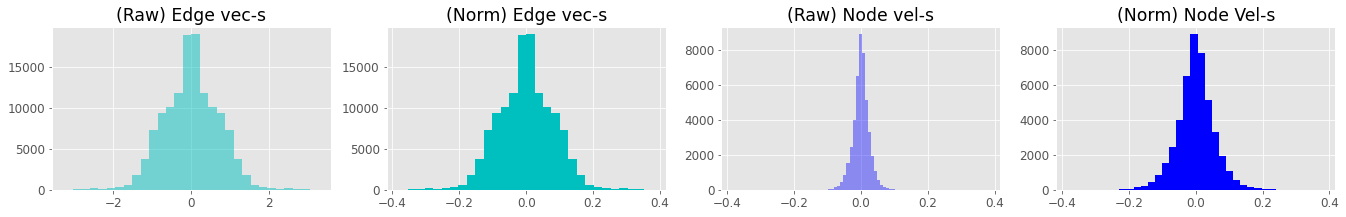

In [92]:
v_vel = torch.cat([d.y for d in vtxdata],0)
e_vec = torch.cat([(d.pos[d.edge_index[1]]-d.pos[d.edge_index[0]]) for d in vtxdata],0)

v_spd = v_vel.pow(2).sum(dim=1).sqrt()
e_len = e_vec.pow(2).sum(dim=1).sqrt()

print(f'> Edge len\n\trange: [{e_len.min():4.3g} {e_len.max():4.3g}]; s.d.: {e_len.std():4.3g} ||'+
      f' median: {e_len.median():4.3g}; mean: {e_len.mean():4.3g};')
print(f'> Node speed\n\trange: [{v_spd.min():4.3g} {v_spd.max():4.3g}]; s.d.: {v_spd.std():4.3g} ||'+
      f' median: {v_spd.median():4.3g}; mean: {v_spd.mean():4.3g};')

print(f'Edge vect-s\n\trange: [{e_vec.min():4.3g} {e_vec.max():4.3g}]; s.d.: {e_vec.std():4.3g} ||'+
      f' median: {e_vec.median():4.3g}; mean: {e_vec.mean():4.3g};')
print(f'Node velocity\n\trange: [{v_vel.min():4.3g} {v_vel.max():4.3g}]; s.d.: {v_vel.std():4.3g} ||'+
      f' median: {v_vel.median():4.3g}; mean: {v_vel.mean():4.3g};')

# After transforms (normalisation and scaling)
v_vel2 = torch.cat([d.y for d in vtxdata_norm],0)
e_vec2 = torch.cat([d.edge_attr for d in vtxdata_norm],0)

print(f'Edge vect-s (transform)\n\trange: [{e_vec2.min():4.3g} {e_vec2.max():4.3g}]; s.d.: {e_vec2.std():4.3g} ||'+
      f' median: {e_vec2.median():4.3g}; mean: {e_vec2.mean():4.3g};')
print(f'Node velocity (transform)\n\trange: [{v_vel2.min():4.3g} {v_vel2.max():4.3g}]; s.d.: {v_vel2.std():4.3g} ||'+
      f' median: {v_vel2.median():4.3g}; mean: {v_vel2.mean():4.3g};')

plt.figure(figsize=[23,3])
ax1 = plt.subplot(1,4,1)
ax1.hist(np.concatenate([e_vec.view(-1,).numpy(), -e_vec.view(-1,).numpy()]),bins=30,color='c',alpha=.5);
ax1.set_title('(Raw) Edge vec-s')

ax2 = plt.subplot(1,4,2)
ax2.hist(np.concatenate([e_vec2.view(-1,).numpy(), -e_vec2.view(-1,).numpy()]),bins=30,color='c');
ax2.set_title('(Norm) Edge vec-s')

ax3 = plt.subplot(1,4,3,sharex=ax2)
ax3.hist(v_vel.view(-1,).numpy(),bins=30,color='b',alpha=.4);
ax3.set_title('(Raw) Node vel-s')

ax4 = plt.subplot(1,4,4,sharex=ax2)
ax4.hist(v_vel2.view(-1,).numpy(),bins=30,color='b');
ax4.set_title('(Norm) Node Vel-s');

> Cell Press-s
	range: [-0.069 2.41]; s.d.:  0.4 || median: 1.05; mean: 1.06;
> Edge Tens-s
	range: [0.0335 3.86]; s.d.: 0.53 || median: 1.35; mean: 1.45;
> Cell Press-s (norm)
	range: [-0.356 0.469]; s.d.: 0.133 || median: 0.0152; mean: 0.0196;
> Edge Tens-s (norm)
	range: [-0.283 0.482]; s.d.: 0.106 || median: -0.0196; mean: -0.000135;


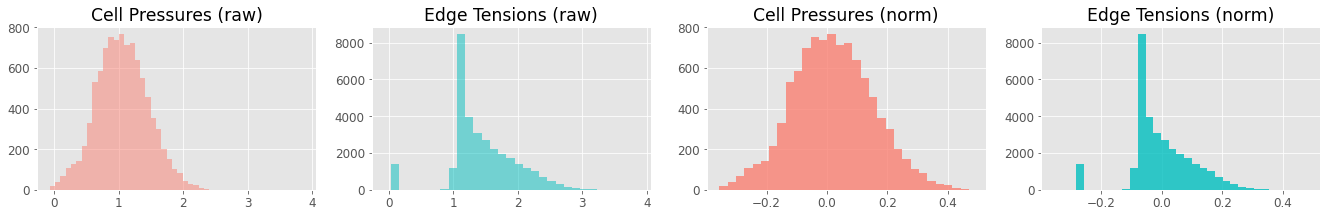

In [93]:
c_pres = torch.cat([d.cell_pressures for d in vtxdata],0)
e_tens = torch.cat([d.edge_tensions for d in vtxdata],0)
print(f'> Cell Press-s\n\trange: [{c_pres.min():4.3g} {c_pres.max():4.3g}]; s.d.: {c_pres.std():4.3g} ||'+
      f' median: {c_pres.median():4.3g}; mean: {c_pres.mean():4.3g};')
print(f'> Edge Tens-s\n\trange: [{e_tens.min():4.3g} {e_tens.max():4.3g}]; s.d.: {e_tens.std():4.3g} ||'+
      f' median: {e_tens.median():4.3g}; mean: {e_tens.mean():4.3g};')

c_pres_norm = torch.cat([d.cell_pressures for d in vtxdata_norm],0)
e_tens_norm = torch.cat([d.edge_tensions for d in vtxdata_norm],0)
print(f'> Cell Press-s (norm)\n\trange: [{c_pres_norm.min():4.3g} {c_pres_norm.max():4.3g}]; s.d.: {c_pres_norm.std():4.3g} ||'+
      f' median: {c_pres_norm.median():4.3g}; mean: {c_pres_norm.mean():4.3g};')
print(f'> Edge Tens-s (norm)\n\trange: [{e_tens_norm.min():4.3g} {e_tens_norm.max():4.3g}]; s.d.: {e_tens_norm.std():4.3g} ||'+
      f' median: {e_tens_norm.median():4.3g}; mean: {e_tens_norm.mean():4.3g};')

plt.figure(figsize=[23,3])
ax1 = plt.subplot(1,4,1)
ax1.hist(c_pres.view(-1,).numpy(),bins=30,color='salmon', alpha=.5);
ax1.set_title('Cell Pressures (raw)')

ax2 = plt.subplot(1,4,2,sharex=ax1)
ax2.hist(e_tens.view(-1,).numpy(),bins=30,color='c', alpha=.5);
ax2.set_title('Edge Tensions (raw)');

ax3 = plt.subplot(1,4,3)
ax3.hist(c_pres_norm.view(-1,).numpy(),bins=30,color='salmon', alpha=.8);
ax3.set_title('Cell Pressures (norm)')

ax4 = plt.subplot(1,4,4, sharex=ax3)
ax4.hist(e_tens_norm.view(-1,).numpy(),bins=30,color='c', alpha=.8);
ax4.set_title('Edge Tensions (norm)');

#### Exponential Modulation Simulations with Random Ka, Kp, A0, P0

- Average edge length `l_avg ~ 1.0`
- Exponential modulation e.g. `Lambda_ij= lambda mg,t: lmd_ij_ON ** torch.cos(omega_ij*t+phase_ij)**2` results in higher contractions (higher Lambda_ij on average) compared to `lmd_ij_ON * torch.cos(omega_ij*t+phase_ij)**2`.

In [43]:
vtxdata = VertexDynamics('./simgnn_data/expmodulation_sims1/')

# Normalisation: for simulated data
Tnorm = T.Compose([Pos2Vec(scale=1.0*10.0) ,
                   ScaleVelocity(1.0*0.5), 
                   ScaleTension(5,shift=1.45),
                   ScalePressure(3, shift=0.565)])
vtxdata_norm = VertexDynamics('./simgnn_data/single_distr_sims1/',transform=Tnorm)

Example 55:
CellData(cell2node_index=[2, 768], cell_pressures=[128], edge_index=[2, 431], edge_tensions=[431], node2cell_index=[2, 768], pos=[304, 2], x=[304, 5, 2], y=[304, 2])
128 cells



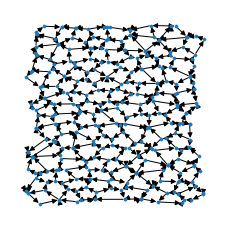

In [44]:
k=55
print('Example {}:\n{}\n{} cells\n'.format(k,vtxdata[k],vtxdata[k].num_cells))
plt.figure(figsize=[3,3])
nx.draw(to_networkx(vtxdata[k]),pos=dict(enumerate(vtxdata[k].pos.numpy())), node_size=10)

> Edge len
	range: [3.44e-06 3.92]; s.d.: 0.559 || median: 0.976; mean: 0.929;
> Node speed
	range: [3.51e-05 0.385]; s.d.: 0.0408 || median: 0.0494; mean: 0.0585;
Edge vect-s
	range: [-3.92 3.26]; s.d.: 0.767 || median: -0.00011; mean: -0.000975;
Node velocity
	range: [-0.347 0.383]; s.d.: 0.0505 || median: -0.000191; mean: -2.85e-09;
Edge vect-s (transform)
	range: [-0.392 0.326]; s.d.: 0.0767 || median: -1.1e-05; mean: -9.75e-05;
Node velocity (transform)
	range: [-0.693 0.766]; s.d.: 0.101 || median: -0.000381; mean: -5.7e-09;


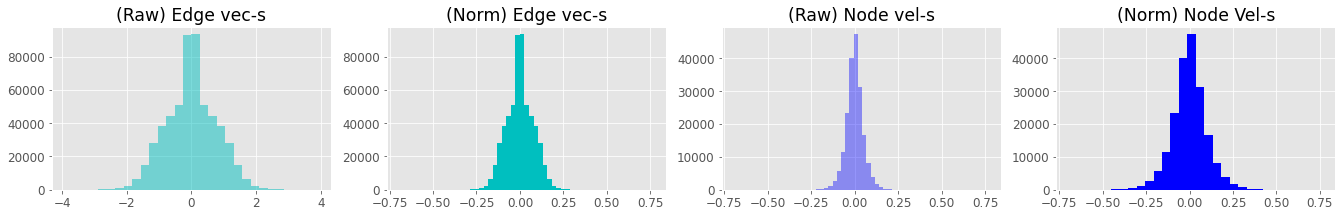

In [45]:
v_vel = torch.cat([d.y for d in vtxdata],0)
e_vec = torch.cat([(d.pos[d.edge_index[1]]-d.pos[d.edge_index[0]]) for d in vtxdata],0)

v_spd = v_vel.pow(2).sum(dim=1).sqrt()
e_len = e_vec.pow(2).sum(dim=1).sqrt()

print(f'> Edge len\n\trange: [{e_len.min():4.3g} {e_len.max():4.3g}]; s.d.: {e_len.std():4.3g} ||'+
      f' median: {e_len.median():4.3g}; mean: {e_len.mean():4.3g};')
print(f'> Node speed\n\trange: [{v_spd.min():4.3g} {v_spd.max():4.3g}]; s.d.: {v_spd.std():4.3g} ||'+
      f' median: {v_spd.median():4.3g}; mean: {v_spd.mean():4.3g};')

print(f'Edge vect-s\n\trange: [{e_vec.min():4.3g} {e_vec.max():4.3g}]; s.d.: {e_vec.std():4.3g} ||'+
      f' median: {e_vec.median():4.3g}; mean: {e_vec.mean():4.3g};')
print(f'Node velocity\n\trange: [{v_vel.min():4.3g} {v_vel.max():4.3g}]; s.d.: {v_vel.std():4.3g} ||'+
      f' median: {v_vel.median():4.3g}; mean: {v_vel.mean():4.3g};')

# After transforms (normalisation and scaling)
v_vel2 = torch.cat([d.y for d in vtxdata_norm],0)
e_vec2 = torch.cat([d.edge_attr for d in vtxdata_norm],0)

print(f'Edge vect-s (transform)\n\trange: [{e_vec2.min():4.3g} {e_vec2.max():4.3g}]; s.d.: {e_vec2.std():4.3g} ||'+
      f' median: {e_vec2.median():4.3g}; mean: {e_vec2.mean():4.3g};')
print(f'Node velocity (transform)\n\trange: [{v_vel2.min():4.3g} {v_vel2.max():4.3g}]; s.d.: {v_vel2.std():4.3g} ||'+
      f' median: {v_vel2.median():4.3g}; mean: {v_vel2.mean():4.3g};')

plt.figure(figsize=[23,3])
ax1 = plt.subplot(1,4,1)
ax1.hist(np.concatenate([e_vec.view(-1,).numpy(), -e_vec.view(-1,).numpy()]),bins=30,color='c',alpha=.5);
ax1.set_title('(Raw) Edge vec-s')

ax2 = plt.subplot(1,4,2)
ax2.hist(np.concatenate([e_vec2.view(-1,).numpy(), -e_vec2.view(-1,).numpy()]),bins=30,color='c');
ax2.set_title('(Norm) Edge vec-s')

ax3 = plt.subplot(1,4,3,sharex=ax2)
ax3.hist(v_vel.view(-1,).numpy(),bins=30,color='b',alpha=.4);
ax3.set_title('(Raw) Node vel-s')

ax4 = plt.subplot(1,4,4,sharex=ax2)
ax4.hist(v_vel2.view(-1,).numpy(),bins=30,color='b');
ax4.set_title('(Norm) Node Vel-s');

> Cell Press-s
	range: [-1.32 4.35]; s.d.: 0.571 || median: 0.567; mean: 0.565;
> Edge Tens-s
	range: [0.0221 5.63]; s.d.: 0.684 || median:  1.3; mean: 1.52;
> Cell Press-s (norm)
	range: [-0.627 1.26]; s.d.: 0.19 || median: 0.000645; mean: -2.67e-06;
> Edge Tens-s (norm)
	range: [-0.286 0.835]; s.d.: 0.137 || median: -0.0309; mean: 0.0144;


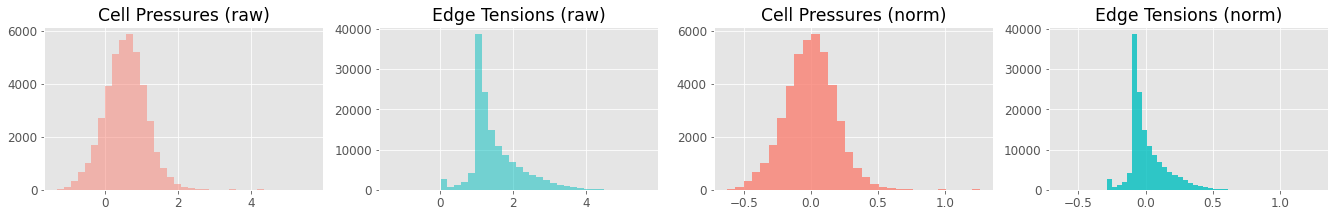

In [46]:
c_pres = torch.cat([d.cell_pressures for d in vtxdata],0)
e_tens = torch.cat([d.edge_tensions for d in vtxdata],0)
print(f'> Cell Press-s\n\trange: [{c_pres.min():4.3g} {c_pres.max():4.3g}]; s.d.: {c_pres.std():4.3g} ||'+
      f' median: {c_pres.median():4.3g}; mean: {c_pres.mean():4.3g};')
print(f'> Edge Tens-s\n\trange: [{e_tens.min():4.3g} {e_tens.max():4.3g}]; s.d.: {e_tens.std():4.3g} ||'+
      f' median: {e_tens.median():4.3g}; mean: {e_tens.mean():4.3g};')

c_pres_norm = torch.cat([d.cell_pressures for d in vtxdata_norm],0)
e_tens_norm = torch.cat([d.edge_tensions for d in vtxdata_norm],0)
print(f'> Cell Press-s (norm)\n\trange: [{c_pres_norm.min():4.3g} {c_pres_norm.max():4.3g}]; s.d.: {c_pres_norm.std():4.3g} ||'+
      f' median: {c_pres_norm.median():4.3g}; mean: {c_pres_norm.mean():4.3g};')
print(f'> Edge Tens-s (norm)\n\trange: [{e_tens_norm.min():4.3g} {e_tens_norm.max():4.3g}]; s.d.: {e_tens_norm.std():4.3g} ||'+
      f' median: {e_tens_norm.median():4.3g}; mean: {e_tens_norm.mean():4.3g};')

plt.figure(figsize=[23,3])
ax1 = plt.subplot(1,4,1)
ax1.hist(c_pres.view(-1,).numpy(),bins=30,color='salmon', alpha=.5);
ax1.set_title('Cell Pressures (raw)')

ax2 = plt.subplot(1,4,2,sharex=ax1)
ax2.hist(e_tens.view(-1,).numpy(),bins=30,color='c', alpha=.5);
ax2.set_title('Edge Tensions (raw)');

ax3 = plt.subplot(1,4,3)
ax3.hist(c_pres_norm.view(-1,).numpy(),bins=30,color='salmon', alpha=.8);
ax3.set_title('Cell Pressures (norm)')

ax4 = plt.subplot(1,4,4, sharex=ax3)
ax4.hist(e_tens_norm.view(-1,).numpy(),bins=30,color='c', alpha=.8);
ax4.set_title('Edge Tensions (norm)');

In [71]:
# lmd_ij_ON = torch.normal(mean=2.1,std=1.0,size=(500,1) ).clamp_(0,6).type(dtype).to(device)
# omega_ij = 0.6 * np.pi * torch.rand_like(lmd_ij_ON) # in [0, N_peaks_max*pi]
# phase_ij = 0.5*np.pi*torch.rand_like(lmd_ij_ON) # in [0, 0.5*pi]; Phase --> cos2 value at t=0

# Lambda_ij_exp= lambda mg,t: lmd_ij_ON**torch.cos(omega_ij*t+phase_ij)**2
# Lambda_ij= lambda mg,t: lmd_ij_ON*torch.cos(omega_ij*t+phase_ij)**2

# t=0
# plt.hist(Lambda_ij_exp(None,t).cpu().reshape(-1,).numpy(), label='exp');
# plt.hist(Lambda_ij(None,t).cpu().reshape(-1,).numpy(), label='non_exp',alpha=.8);
# plt.title("exponent modulation vs normal modulation");
# plt.legend();

#### Simul-s from a Single Distribution

```python
# # # Cell param-s # # #
    Ka_cells = torch.normal(mean=1.0,std=0.1,size=(len(m.cells),) ).clamp_(0.75,1.25).type(dtype).to(device)
    A0_cells = torch.normal(mean=2.3,std=0.25,size=(len(m.cells),) ).clamp_(1.6,3).type(dtype).to(device)
    P0_cells = torch.normal(mean=0,std=0.15,size=(len(m.cells),1) ).clamp_(0,).type(dtype).to(device)
    Kp_cells = torch.normal(mean=0.003,std=0.001,size=(len(m.cells),1) ).clamp_(0.0001,).type(dtype).to(device)

    # "lambda_ij" amplitudes ~ Normal(mu=2.1,s.d.=.5) [clamped]
    # oscillation freq-s; unit_of_time = 1 min = 1/Dt : Dt:simulation time step size
    lmd_ij_ON = torch.normal(mean=1.0,std=1.0,size=( m.edges.size(0),1) ).clamp_(0,6).type(dtype).to(device)
    omega_ij = N_peaks_max*np.pi*torch.rand_like(lmd_ij_ON) # in [0, N_peaks_max*pi]
    phase_ij = 0.5*np.pi*torch.rand_like(lmd_ij_ON) # in [0, 0.5*pi]; Phase --> cos2 value at t=0
    
    sim_params = {'Ka': lambda mg,t: Ka_cells, 'A0': lambda mg,t: A0_cells,
                  'Kp': lambda mg,t: Kp_cells, 'P0': lambda mg,t: P0_cells,
                  'Lambda_ij': lambda mg,t: lmd_ij_ON*torch.cos(omega_ij*t+phase_ij)**2}
```

In [137]:
vtxdata = VertexDynamics('./simgnn_data/single_distr_sims/')

# Normalisation: for simulated data
Tnorm = T.Compose([Pos2Vec(scale=1.0*10.0) ,
                   ScaleVelocity(1.0*0.5), 
                   ScaleTension(0.634,shift=0.6),
                   ScalePressure(0.33, shift=0.1)])
vtxdata_norm = VertexDynamics('./simgnn_data/single_distr_sims/',transform=Tnorm)

Example 140:
CellData(cell2node_index=[2, 480], cell_pressures=[80], edge_index=[2, 275], edge_tensions=[275], node2cell_index=[2, 480], pos=[196, 2], x=[196, 5, 2], y=[196, 2])
80 cells



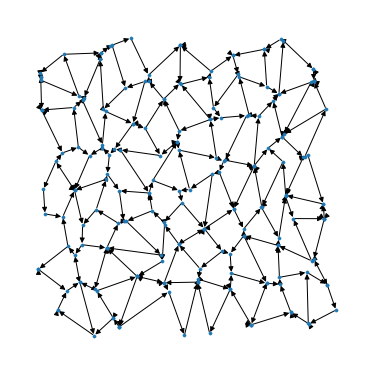

In [132]:
k=140
print('Example {}:\n{}\n{} cells\n'.format(k,vtxdata[k],vtxdata[k].num_cells))
plt.figure(figsize=[5,5])
nx.draw(to_networkx(vtxdata[k]),pos=dict(enumerate(vtxdata[k].pos.numpy())), node_size=10)

> Edge len
	range: [2.13e-06 3.84]; s.d.: 0.788 || median:  1.1; mean: 1.08;
> Node speed
	range: [7.69e-06 0.418]; s.d.: 0.0418 || median: 0.042; mean: 0.0528;
Edge vect-s
	range: [-3.55 3.84]; s.d.: 0.945 || median: -7.25e-05; mean: -0.000826;
Node velocity
	range: [-0.364 0.384]; s.d.: 0.0476 || median: -7.32e-05; mean: 1.05e-08;
Edge vect-s (transform)
	range: [-0.355 0.384]; s.d.: 0.0945 || median: -7.25e-06; mean: -8.26e-05;
Node velocity (transform)
	range: [-0.729 0.768]; s.d.: 0.0952 || median: -0.000146; mean: 2.09e-08;


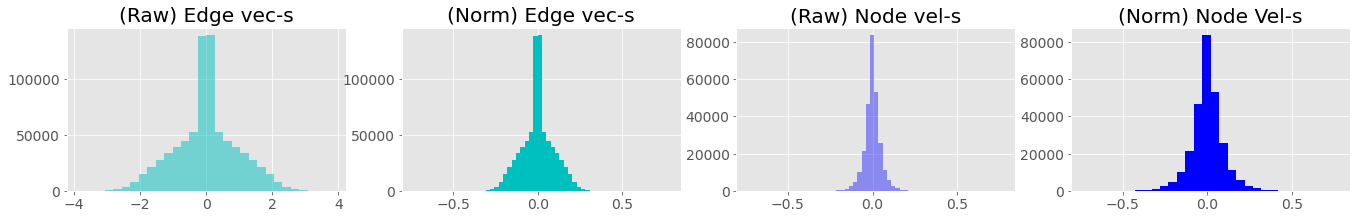

In [138]:
v_vel = torch.cat([d.y for d in vtxdata],0)
e_vec = torch.cat([(d.pos[d.edge_index[1]]-d.pos[d.edge_index[0]]) for d in vtxdata],0)

v_spd = v_vel.pow(2).sum(dim=1).sqrt()
e_len = e_vec.pow(2).sum(dim=1).sqrt()

print(f'> Edge len\n\trange: [{e_len.min():4.3g} {e_len.max():4.3g}]; s.d.: {e_len.std():4.3g} ||'+
      f' median: {e_len.median():4.3g}; mean: {e_len.mean():4.3g};')
print(f'> Node speed\n\trange: [{v_spd.min():4.3g} {v_spd.max():4.3g}]; s.d.: {v_spd.std():4.3g} ||'+
      f' median: {v_spd.median():4.3g}; mean: {v_spd.mean():4.3g};')

print(f'Edge vect-s\n\trange: [{e_vec.min():4.3g} {e_vec.max():4.3g}]; s.d.: {e_vec.std():4.3g} ||'+
      f' median: {e_vec.median():4.3g}; mean: {e_vec.mean():4.3g};')
print(f'Node velocity\n\trange: [{v_vel.min():4.3g} {v_vel.max():4.3g}]; s.d.: {v_vel.std():4.3g} ||'+
      f' median: {v_vel.median():4.3g}; mean: {v_vel.mean():4.3g};')

# After transforms (normalisation and scaling)
v_vel2 = torch.cat([d.y for d in vtxdata_norm],0)
e_vec2 = torch.cat([d.edge_attr for d in vtxdata_norm],0)

print(f'Edge vect-s (transform)\n\trange: [{e_vec2.min():4.3g} {e_vec2.max():4.3g}]; s.d.: {e_vec2.std():4.3g} ||'+
      f' median: {e_vec2.median():4.3g}; mean: {e_vec2.mean():4.3g};')
print(f'Node velocity (transform)\n\trange: [{v_vel2.min():4.3g} {v_vel2.max():4.3g}]; s.d.: {v_vel2.std():4.3g} ||'+
      f' median: {v_vel2.median():4.3g}; mean: {v_vel2.mean():4.3g};')

plt.figure(figsize=[23,3])
ax1 = plt.subplot(1,4,1)
ax1.hist(np.concatenate([e_vec.view(-1,).numpy(), -e_vec.view(-1,).numpy()]),bins=30,color='c',alpha=.5);
ax1.set_title('(Raw) Edge vec-s')

ax2 = plt.subplot(1,4,2)
ax2.hist(np.concatenate([e_vec2.view(-1,).numpy(), -e_vec2.view(-1,).numpy()]),bins=30,color='c');
ax2.set_title('(Norm) Edge vec-s')

ax3 = plt.subplot(1,4,3,sharex=ax2)
ax3.hist(v_vel.view(-1,).numpy(),bins=30,color='b',alpha=.4);
ax3.set_title('(Raw) Node vel-s')

ax4 = plt.subplot(1,4,4,sharex=ax2)
ax4.hist(v_vel2.view(-1,).numpy(),bins=30,color='b');
ax4.set_title('(Norm) Node Vel-s');

> Cell Press-s
	range: [-1.37 2.37]; s.d.: 0.333 || median: 0.0635; mean: 0.0766;
> Edge Tens-s
	range: [0.00131 4.26]; s.d.: 0.634 || median: 0.302; mean: 0.573;
> Cell Press-s (norm)
	range: [-4.45 6.89]; s.d.: 1.01 || median: -0.111; mean: -0.0708;
> Edge Tens-s (norm)
	range: [-0.944 5.77]; s.d.:    1 || median: -0.471; mean: -0.0424;


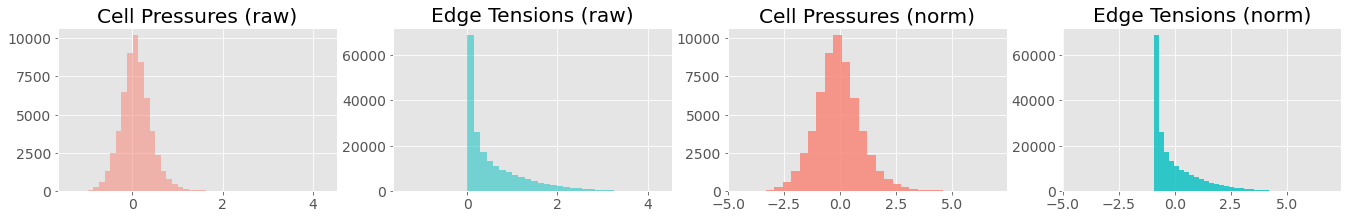

In [139]:
c_pres = torch.cat([d.cell_pressures for d in vtxdata],0)
e_tens = torch.cat([d.edge_tensions for d in vtxdata],0)
print(f'> Cell Press-s\n\trange: [{c_pres.min():4.3g} {c_pres.max():4.3g}]; s.d.: {c_pres.std():4.3g} ||'+
      f' median: {c_pres.median():4.3g}; mean: {c_pres.mean():4.3g};')
print(f'> Edge Tens-s\n\trange: [{e_tens.min():4.3g} {e_tens.max():4.3g}]; s.d.: {e_tens.std():4.3g} ||'+
      f' median: {e_tens.median():4.3g}; mean: {e_tens.mean():4.3g};')

c_pres_norm = torch.cat([d.cell_pressures for d in vtxdata_norm],0)
e_tens_norm = torch.cat([d.edge_tensions for d in vtxdata_norm],0)
print(f'> Cell Press-s (norm)\n\trange: [{c_pres_norm.min():4.3g} {c_pres_norm.max():4.3g}]; s.d.: {c_pres_norm.std():4.3g} ||'+
      f' median: {c_pres_norm.median():4.3g}; mean: {c_pres_norm.mean():4.3g};')
print(f'> Edge Tens-s (norm)\n\trange: [{e_tens_norm.min():4.3g} {e_tens_norm.max():4.3g}]; s.d.: {e_tens_norm.std():4.3g} ||'+
      f' median: {e_tens_norm.median():4.3g}; mean: {e_tens_norm.mean():4.3g};')

plt.figure(figsize=[23,3])
ax1 = plt.subplot(1,4,1)
ax1.hist(c_pres.view(-1,).numpy(),bins=30,color='salmon', alpha=.5);
ax1.set_title('Cell Pressures (raw)')

ax2 = plt.subplot(1,4,2,sharex=ax1)
ax2.hist(e_tens.view(-1,).numpy(),bins=30,color='c', alpha=.5);
ax2.set_title('Edge Tensions (raw)');

ax3 = plt.subplot(1,4,3)
ax3.hist(c_pres_norm.view(-1,).numpy(),bins=30,color='salmon', alpha=.8);
ax3.set_title('Cell Pressures (norm)')

ax4 = plt.subplot(1,4,4, sharex=ax3)
ax4.hist(e_tens_norm.view(-1,).numpy(),bins=30,color='c', alpha=.8);
ax4.set_title('Edge Tensions (norm)');

### Normalising Hara movies (no force information) and comparing w/ simulations 

In [117]:
SAMPLE_NAME = 'Seg_001'
root_dir = 'simgnn_data/hara_movies/raw/'
dataDir = path.join(root_dir, SAMPLE_NAME)

edges_index = load_array(path.join(dataDir, 'edges_index.npy'))
node2cell_index = load_array(path.join(dataDir, 'node2cell_index.npy'))
v_pos = load_array(path.join(dataDir, 'vtx_pos.npy'))
eij_lens = load_array(path.join(dataDir, 'edge_Length.npy'))
# l_Re_0 = eij_lens.mean()

In [118]:
e_vec2_Re = v_pos[:,edges_index[1],:] - v_pos[:,edges_index[0],:]
e_vec2_Re_norm = e_vec2_Re/(26.32*10)

v_vel_Re = np.diff(v_pos,axis=0)
v_vel_Re_norm = v_vel_Re/(26.32*0.5)

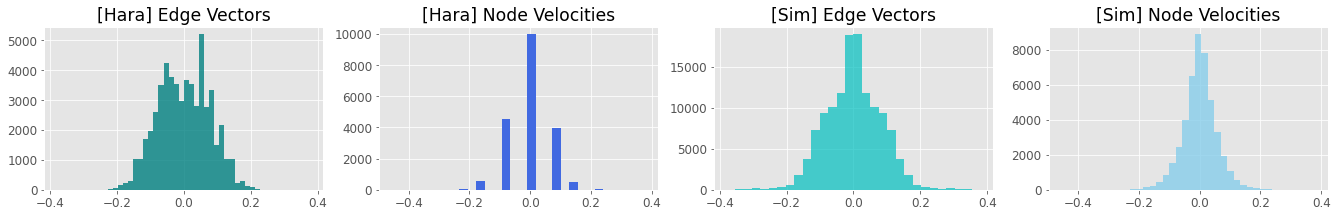

In [119]:
plt.figure(figsize=[23,3])
ax1 = plt.subplot(1,4,1)
ax1.hist(np.concatenate([e_vec2_Re_norm.ravel(),-e_vec2_Re_norm.ravel()]),bins=30,color='teal',alpha=.8);
ax1.set_title('[Hara] Edge Vectors')

ax2 = plt.subplot(1,4,2)
ax2.hist(v_vel_Re_norm.ravel(),bins=30,color='royalblue');
ax2.set_title('[Hara] Node Velocities');

ax3 = plt.subplot(1,4,3,sharex=ax1)
ax3.hist(np.concatenate([e_vec2.view(-1,).numpy(), -e_vec2.view(-1,).numpy()]),bins=30,color='c',alpha=.7);
ax3.set_title('[Sim] Edge Vectors')

ax4 = plt.subplot(1,4,4, sharex=ax2)
ax4.hist(v_vel2.view(-1,).numpy(),bins=30,color='skyblue',alpha=.8);
ax4.set_title('[Sim] Node Velocities');

### Same normalised Hara movies dataset using `HaraMovies` graph dataset implementation
- `HaraMovies` class could be used to combine all three movies.

In [140]:
T_hara_movie_norm = T.Compose([Pos2Vec(scale=10*26.32) ,
                           ScaleVelocity(0.5*26.32)]) # data normalisation
hara_movs = HaraMovies('simgnn_data/hara_movies/', transform=T_hara_movie_norm)

- to select 1st movie below use  `hara_movs[:50]` instead of the full `hara_movs` in `torch.cat([d.y for d in hara_movs],0)`

Hara movie dataset:
- - - - - - - - - - 
Edge vect-s (transform)
	range: [-0.836 0.912]; s.d.: 0.064 || median:    0; mean: -0.00452;
Node velocity (transform)
	range: [-0.228 0.228]; s.d.: 0.0696 || median:   -0; mean:    0;


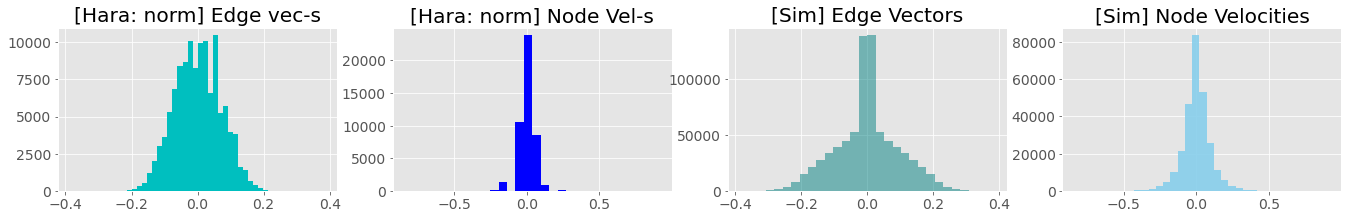

In [142]:
v_vel_Re_norm = torch.cat([d.y for d in hara_movs],0)
e_vec2_Re_norm = torch.cat([d.edge_attr for d in hara_movs],0) # assumes non-directed graph, to convert to directed copy and
e_vec2_Re_norm = torch.cat([e_vec2_Re_norm.view(-1,), -e_vec2_Re_norm.view(-1,)])
print('Hara movie dataset:\n'+10*"- ")
print(f'Edge vect-s (transform)\n\trange: [{v_vel_Re_norm.min():4.3g} {v_vel_Re_norm.max():4.3g}]; s.d.: {v_vel_Re_norm.std():4.3g} ||'+
      f' median: {v_vel_Re_norm.median():4.3g}; mean: {v_vel_Re_norm.mean():4.3g};')
print(f'Node velocity (transform)\n\trange: [{e_vec2_Re_norm.min():4.3g} {e_vec2_Re_norm.max():4.3g}]; s.d.: {e_vec2_Re_norm.std():4.3g} ||'+
      f' median: {e_vec2_Re_norm.median():4.3g}; mean: {e_vec2_Re_norm.mean():4.3g};')

plt.figure(figsize=[23,3])
ax1 = plt.subplot(1,4,1)
ax1.hist(e_vec2_Re_norm.numpy(),bins=30,color='c');
ax1.set_title('[Hara: norm] Edge vec-s')

ax2 = plt.subplot(1,4,2)
ax2.hist(v_vel_Re_norm.view(-1,).numpy(),bins=30,color='b');
ax2.set_title('[Hara: norm] Node Vel-s');

ax3 = plt.subplot(1,4,3,sharex=ax1)
ax3.hist(np.concatenate([e_vec2.view(-1,).numpy(), -e_vec2.view(-1,).numpy()]),bins=30,color='teal',alpha=.5);
ax3.set_title('[Sim] Edge Vectors')

ax4 = plt.subplot(1,4,4,sharex=ax2)
ax4.hist(v_vel2.view(-1,).numpy(),bins=30,color='skyblue',alpha=.9);
ax4.set_title('[Sim] Node Velocities');

- This hist plots whatever simulation dataset is assigned to `e_vec2` and `v_vel2` **!!!**

In [111]:
# # # # Sampling P0's (or A0's)
# plt.hist(torch.normal(mean=1.,std=.5,size=(500,) ).clamp_(0,6).numpy(),alpha=.8,
#         label=f'{1.0};{0.5}');

# plt.hist(torch.normal(mean=0.25,std=1.5,size=(500,) ).clamp_(0,6).numpy(),color='orange',alpha=.5,
#         label=f'{0.25};{1.5}');

# plt.hist(torch.normal(mean=1.,std=1.,size=(500,) ).clamp_(0,6).numpy(),alpha=.4,color='b',
#          label=f'{1.0};{1.0}');

# plt.legend();